In [1]:
# Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import stumpy
from matplotlib.patches import Rectangle
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import Image
from scipy.stats import boxcox
from pmdarima import auto_arima 
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.metrics import silhouette_score 
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance,TimeSeriesResampler
from tslearn.metrics import cdist_dtw



## Task 5A + B

,close
count,25.000000
mean,0.269957
std,0.008181
min,0.255529
25%,0.263168
50%,0.269128
75%,0.275230
max,0.286742


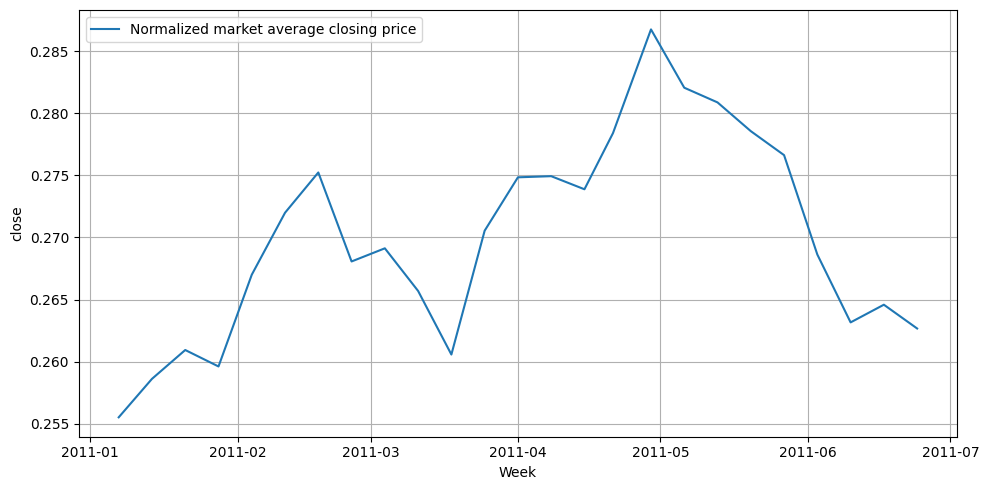

In [2]:
# Dataset has no missing values, the data can not contain missing values since the domain does not allow this. 

# Loading the data, changing the format and datatype of the 'close' column
dow_jones = pd.read_csv('dow_jones_index.data')
dow_jones['close'] = dow_jones['close'].replace({'\\$': ''}, regex=True).astype(float)

# Scaling the data in the 'close' column
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(dow_jones['close']).reshape(-1, 1))
dow_jones = dow_jones.assign(close=scaled_data)

# Creting a new dataframe and aggregating the values as to get the scaled average market value per week
close_df = dow_jones[['date', 'close']]
close_df = close_df.groupby(by=['date']).mean()

close_df = close_df.reset_index()
close_df = close_df.assign(date = [datetime.strptime(date_str, '%m/%d/%Y').date() for date_str in close_df['date']])
close_df = close_df.set_index(close_df['date'])
close_df = close_df.drop(columns=['date'])
close_df = close_df.sort_index()


# Summarizing the data
display(close_df.describe())

# Plotting the timeseries

fig, ax = plt.subplots(1,1, figsize = (10, 5))
sns.lineplot(data=close_df, x='date', y='close', ax=ax, label='Normalized market average closing price')
ax.legend()
ax.set_xlabel('Week')
ax.grid()
plt.tight_layout()
plt.show()

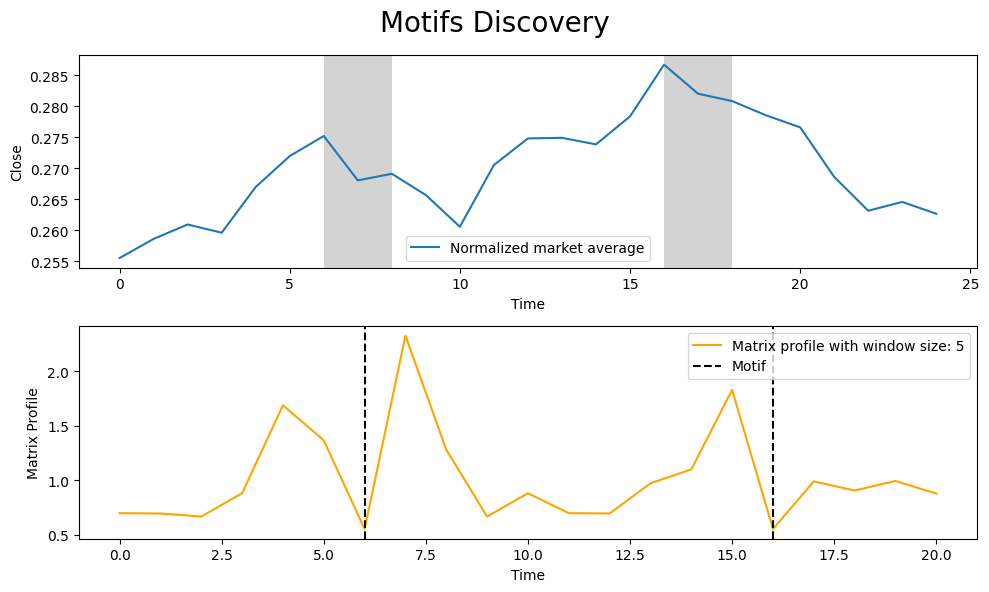

In [3]:
# Creating the matrix profile
m=5
matrix_profile = stumpy.stump(close_df['close'], m=m)
profile = np.array(matrix_profile)[:, 0]

#Finding motifs by getting the index of the smallest values in the matrix profile
motif_idx = np.argsort(profile)[0]
nearest_neighbor_idx = matrix_profile[motif_idx, 1]

# Plotting, inspiration taken from the stumpylibrary
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plt.suptitle('Motifs Discovery', fontsize=20)

sns.lineplot(data=close_df, x=range(len(close_df.index)), y='close', ax=ax1, label='Normalized market average')
ax1.set_ylabel('Close')
ax1.set_xlabel('Time')
rect = Rectangle((motif_idx, 0), 2, 40, facecolor='lightgrey')
ax1.add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), 2, 40, facecolor='lightgrey')
ax1.add_patch(rect)

sns.lineplot(y=profile, x=range(len(profile)), label=f'Matrix profile with window size: {m}', ax=ax2, color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('Matrix Profile')
ax2.axvline(x=motif_idx, linestyle="dashed", color='black', label='Motif')
ax2.axvline(x=nearest_neighbor_idx, linestyle="dashed", color='black')

plt.legend()
plt.tight_layout()
plt.show()

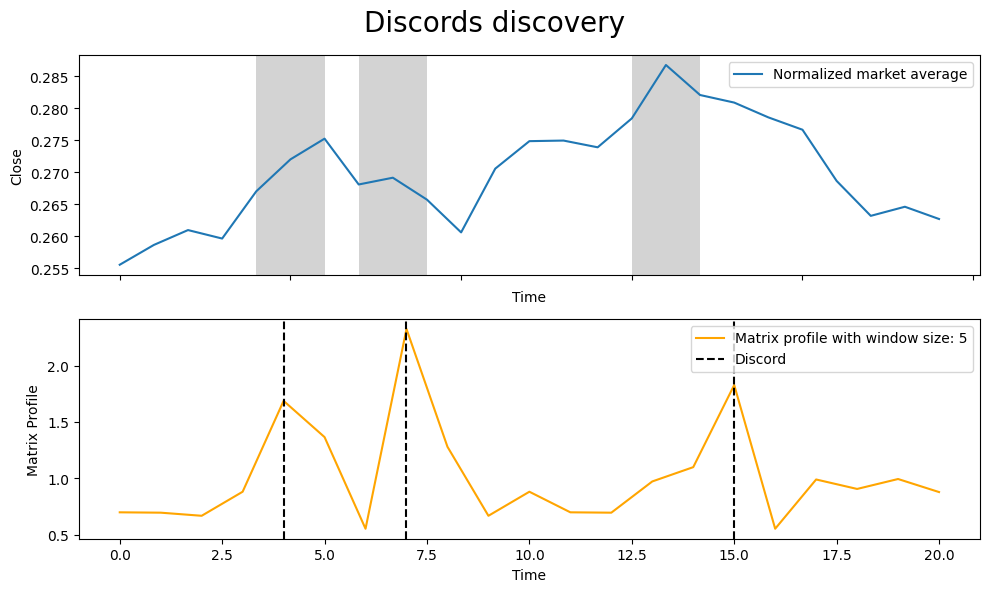

In [4]:
# Finding discords by getting the largest values
discord_idx1 = np.argsort(profile)[-1]
discord_idx2 = np.argsort(profile)[-2]
discord_idx3 = np.argsort(profile)[-3]


# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plt.suptitle('Discords discovery', fontsize=20)

sns.lineplot(data=close_df, x=range(len(close_df.index)), y='close', ax=ax1, label='Normalized market average').set_xticklabels([])
ax1.set_ylabel('Close')
ax1.set_xlabel('Time')
rect = Rectangle((discord_idx1, 0), 2, 40, facecolor='lightgrey')
ax1.add_patch(rect)
rect = Rectangle((discord_idx2, 0), 2, 40, facecolor='lightgrey')
ax1.add_patch(rect)
rect = Rectangle((discord_idx3, 0), 2, 40, facecolor='lightgrey')
ax1.add_patch(rect)

sns.lineplot(y=profile, x=range(len(profile)), label=f'Matrix profile with window size: {m}', ax=ax2, color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('Matrix Profile')
ax2.axvline(x=discord_idx1, linestyle="dashed", color='black', label='Discord')
ax2.axvline(x=discord_idx2, linestyle="dashed", color='black')
ax2.axvline(x=discord_idx3, linestyle="dashed", color='black')


plt.legend()
plt.tight_layout()
plt.show()

2011-02-25
2011-04-01


<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
C:\Users\victo\AppData\Local\Temp\ipykernel_33288\870650787.py:8: SyntaxWarning: invalid escape sequence '\c'
  Image(filename='Images\chatgpt_prompt1.png')


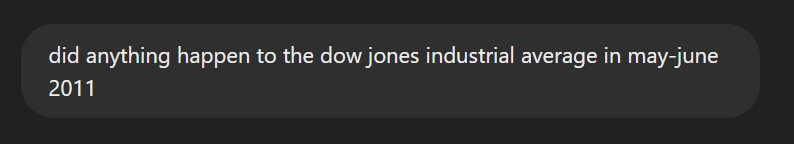

In [5]:
# Anomaly period 1 explanation
anomaly_period1_start = close_df.index[discord_idx1]
anomaly_period1_end = close_df.index[discord_idx1 + m]
print(anomaly_period1_start)
print(anomaly_period1_end)

# ChatGPT prompt to find soucres:
Image(filename='Images\chatgpt_prompt1.png')

# Found these market reports to explain the market:

# https://www.arkansasonline.com/news/2011/jun/10/stocks-rise-1st-time-june-20110610/?utm_source=chatgpt.com
# https://www.marketwatch.com/story/us-stocks-decline-as-investors-mull-quakes-impact-djia-off-118-2011-03-14?utm_source=chatgpt.com


# The stock market broke a six-day losing streak on Thursday, June 9, 2011, with the Dow Jones Industrial Average rising 75.42 points (0.6%) 
# to close at 12,124.36. The rally was driven by a report showing U.S. exports hit a record high in April, which improved economic growth 
# projections. The S&P 500 and Nasdaq also gained 0.7% and 0.4%, respectively.

# The previous slump, caused by poor economic reports on manufacturing, housing, hiring, and consumer confidence, had made stocks appear 
# undervalued. U.S. manufacturers benefitted from a narrower trade deficit, while higher corn prices boosted agricultural equipment stocks 
# like Deere & Co. Energy stocks rose due to a $1.19 increase in oil prices, closing at $101.93 per barrel.

# Despite the rebound, concerns lingered over high unemployment claims, Japan's earthquake impact, and Greece's debt crisis, which had been 
# weighing on markets since mid-April. Consolidated trading volume was 3.5 billion shares, with nearly twice as many stocks rising as falling.

2011-04-21
2011-05-27


<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
C:\Users\victo\AppData\Local\Temp\ipykernel_33288\4232794304.py:7: SyntaxWarning: invalid escape sequence '\c'
  Image(filename='Images\chapgpt_prompt2.png')


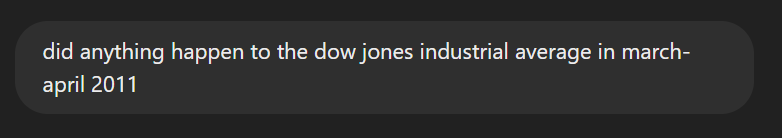

In [6]:
# Anomaly period 2 explanation
anomaly_period2_start = close_df.index[discord_idx2]
anomaly_period2_end = close_df.index[discord_idx2 + m]
print(anomaly_period2_start)
print(anomaly_period2_end)

Image(filename='Images\chapgpt_prompt2.png')

# Found these market reports to explain the market:

# https://www.publishersweekly.com/pw/by-topic/industry-news/financial-reporting/article/47142-industry-stocks-april-2011-performances.html?utm_source=chatgpt.com


# The Dow Jones Industrial Average and the Publishers Weekly Stock Index rose by similar amounts in April, with the Dow ahead 4.8% and t
# he PWSI up 4.3%. The stock prices of nine companies on the PWSI rose in the month while prices declined at four. Barnes & Noble’s stock 
# price continued to be the most volatile in the publishing and bookselling industries. 

# After falling 31% in February, the price rose 19.6% in April as investors try to figure out if B&N is a dying bricks-and-mortar bookstore 
# chain or a print/digital bookstore poised for big growth. Investors have no doubts about Amazon, as the stock price of the e-tailer ran 
# up over $15 in the month. While Wall Street tends to frown on companies that make large investments in their operations, investors seemed 
# to accept Amazon’s argument made in discussing first-quarter results that investments now will pay off in a big way in the future.

In [7]:
anomaly_period2_start = close_df.index[discord_idx3]
anomaly_period2_end = close_df.index[discord_idx3 + m]
print(anomaly_period2_start)
print(anomaly_period2_end)

#### Find source for this ####

2011-02-04
2011-03-11


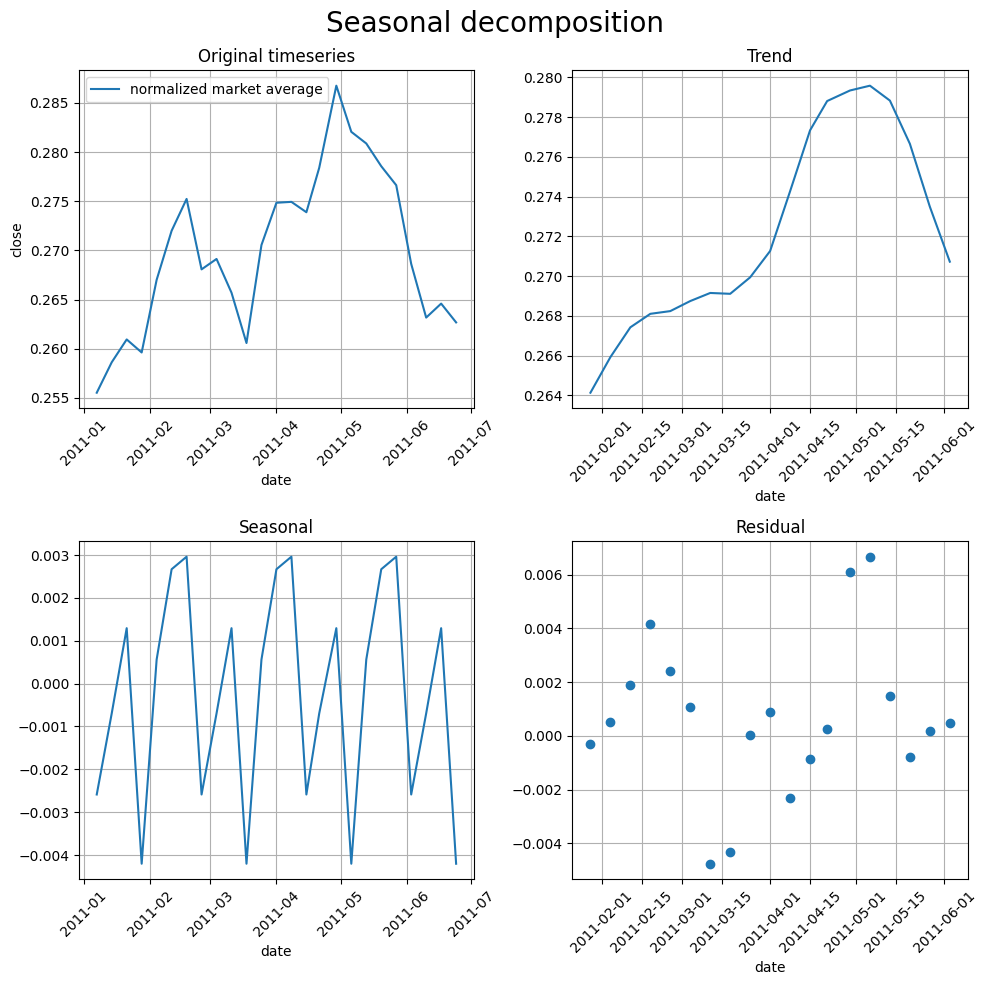

In [8]:
# Seasonal decomposition

# Applying seasonal decompotition with statsmodels.tsa
decomp = seasonal_decompose(close_df['close'], model='additive', period=7)     # I choose additive model here since the variance looks to be constant for this variable

# Plotting'
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Seasonal decomposition', fontsize=20)

sns.lineplot(data=close_df, x=close_df.index, y='close', ax=ax[0, 0], label='normalized market average')
ax[0, 0].set_title('Original timeseries') 
ax[0, 0].grid()
ax[0, 0].tick_params(axis='x', labelrotation = 45)


decomp.trend.plot(ax=ax[0, 1])
ax[0, 1].set_title('Trend')
ax[0, 1].grid()
ax[0, 1].tick_params(axis='x', labelrotation = 45)

decomp.seasonal.plot(ax=ax[1, 0])
ax[1, 0].set_title('Seasonal')
ax[1, 0].grid()
ax[1, 0].tick_params(axis='x', labelrotation = 45)

decomp.resid.plot(marker='o', ax=ax[1, 1], linewidth=0)
ax[1, 1].set_title('Residual')
ax[1, 1].grid()
ax[1, 1].tick_params(axis='x', labelrotation = 45)

plt.tight_layout()
plt.show()

6


<Figure size 640x480 with 0 Axes>

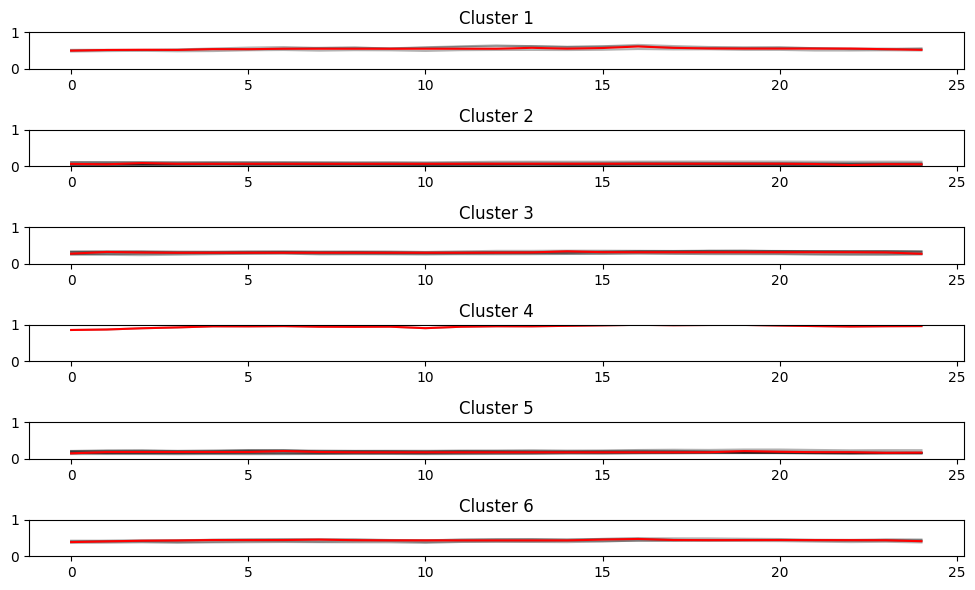

In [9]:
# Timeseries clustering with Dynamic timewarping

# To potentially find more patterns, we can instead look at the non-aggregated but scaled data for the clsutering.
# This gives us a longer stretch of data to look at patterns in, even if we loose the time variable by doing this. 

# Creating data
# Used ChatGPT for the preprocessing since i could not figure out the ducomentation on my own. 

all_stocks = dow_jones[['stock', 'close']]
all_stocks = pd.DataFrame(all_stocks)
all_stocks["group"] = all_stocks.groupby("stock").cumcount()
pivoted_df = all_stocks.pivot(index="group", columns="stock", values="close")
pivoted_df.reset_index(drop=True, inplace=True)
pivoted_df = pivoted_df.T
data = pivoted_df.to_numpy().reshape(pivoted_df.shape[0], pivoted_df.shape[1], 1)

X_train_clsuter = TimeSeriesResampler(sz=25).fit_transform(data)
X_train_cluster= TimeSeriesScalerMeanVariance().fit_transform(X_train_clsuter)

# Creating a function to find the lowest average silhuette score 
def find_optimal_k(data, clusters):
    sil_scores = {}
    for n_clusters in n_clusters_to_try:
        model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
        y_pred = model.fit_predict(data)
        distance_matrix = cdist_dtw(X_train_cluster)

        # Compute and store the silhuette scores
        sil_avg = silhouette_score(distance_matrix, y_pred,  metric="precomputed")
        sil_scores[n_clusters] = sil_avg
    optimal_k = next(key for key, value in sil_scores.items() if value == min(sil_scores.values()))
    return optimal_k, min(sil_scores.values())

# Calling the function to find the optimal k
n_clusters_to_try = range(2, 7, 1)
optimal_k, avg_sil_score = find_optimal_k(X_train_clsuter, n_clusters_to_try)
print(optimal_k)

# Creating the model and making a preduction
model = TimeSeriesKMeans(n_clusters=optimal_k, metric="dtw", random_state=42)
y_pred = model.fit_predict(data)

# Plotting taken from the TSLearn documentation
plt.clf()
plt.figure(figsize=(10, 6))
for yi in range(optimal_k):
    plt.subplot(optimal_k, 1, 1 + yi)
    plt.ylim([0, 1])
    for xx in X_train_clsuter[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.3)
    plt.plot(model.cluster_centers_[yi].ravel(), color="red")
    plt.title("Cluster %d" % (yi + 1))
plt.tight_layout()
plt.show()


## Task 5C

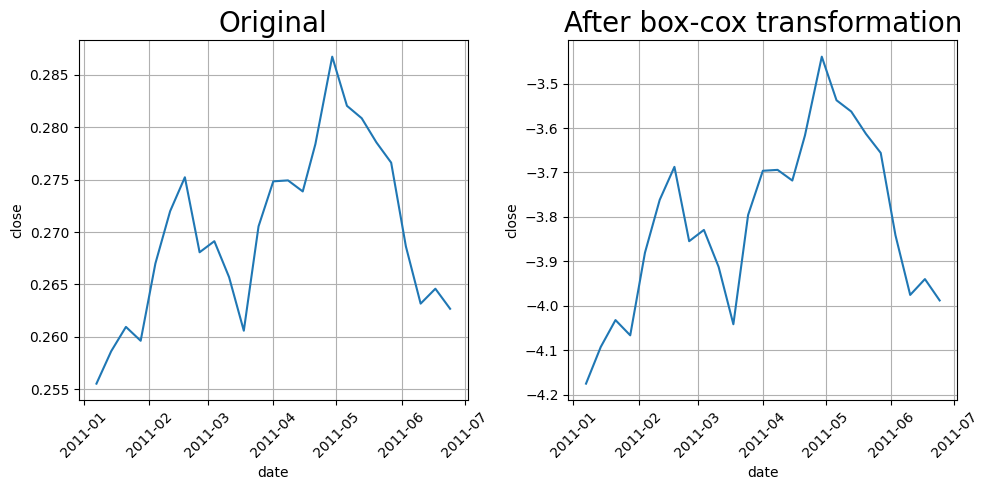

In [10]:
# Since stock markets are typically not stationary and contains trend ans seasonality components as seen in the decomposition, 
# we will use a SARIMA model to predict future values. We do however need to fix the non-constant vairance with a box-cox transformation.

# Box cox transformation 
close_df_boxcox = close_df.assign(close=boxcox(close_df['close'])[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=close_df, x=close_df.index, y='close', ax=ax1)
sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', ax=ax2)
ax1.grid()
ax2.grid()
ax1.tick_params(axis='x', labelrotation = 45)
ax2.tick_params(axis='x', labelrotation = 45)
ax1.set_title('Original', fontsize=20)
ax2.set_title('After box-cox transformation', fontsize=20)
plt.tight_layout()
plt.show()

In [11]:
# 80/20 split
X_train = close_df_boxcox.iloc[:20]
X_test = close_df_boxcox.iloc[20:]

# Creating a SARIMA model that automatically finds the model with the lowest AIC score though iterating over different 
# combinations of p,d,q,P,D,Q paramters. Since the m parameter of the seasonal component does not affect the AIC score

m_vals_to_try = [i+2 for i in range(16)]
aic_scores = []

for m in m_vals_to_try:
    auto_model = auto_arima(X_train, 
                    
                    start_p=1,
                    start_q=1, 
                    d=1, 
                    max_p=10, 
                    max_q=10, 
                    
                    start_P=0,
                    start_Q=0,
                    D=1,
                    max_P=10,
                    max_Q=10,

                    m=m,
                    
                    information_criterion='aic',
                    trace=True, 
                    error_action='ignore',
                    suppress_warnings=True, 
                    stepwise=True)

    auto_model.fit(X_train)
    aic_scores.append({m:auto_model.aic()})
    forecast = auto_model.predict(n_periods=len(X_test))

    #fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    #plt.suptitle(f'SARIMA prediction with m={m}')

    #sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', label='Actual values')
    #sns.lineplot(y=forecast, x=X_test.index, color='red', label='SARIMA'+str(auto_model.order)+str(auto_model.seasonal_order)+' prediction')
    #ax.grid()

    #plt.tight_layout
    #plt.legend()
    #plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[2]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[2]             : AIC=-8.111, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[2]             : AIC=-11.743, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[2]             : AIC=-6.121, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[2]             : AIC=-10.233, Time=0.05 sec
 ARIMA(1,1,0)(1,1,1)[2]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,1,1)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(2,1,1)[2]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(1,1,0)[2]             : AIC=-13.657, Time=0.02 sec
 ARIMA(0,1,0)(2,1,0)[2]             : AIC=-12.195, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[2]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[2]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(2,1,1)[2]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(1,1,0)[2]             : AIC=-11.765, Time=0.03 sec
 ARIMA(1,1,1)(1,

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,1,1)[3]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(1,1,0)[3]             : AIC=-9.869, Time=0.03 sec
 ARIMA(0,1,0)(2,1,0)[3]             : AIC=-9.775, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[3]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[3]             : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(2,1,1)[3]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(1,1,0)[3]             : AIC=-7.932, Time=0.04 sec
 ARIMA(1,1,1)(1,1,0)[3]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(1,1,0)[3] intercept   : AIC=-8.194, Time=0.03 sec

Best model:  ARIMA(0,1,0)(1,1,0)[3]          
Total fit time: 0.609 seconds
Performing stepwise search to minimize aic


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,1,0)[4]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=-10.504, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-9.208, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-11.436, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-8.546, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-7.877, Time=0.03 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=-9.667, Time=0.10 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 1.

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=-6.555, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=-12.103, Time=0.13 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=-12.103, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=-10.103, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[5]             : AIC=-16.053, Time=0.03 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=-14.071, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[5]             : AIC=-14.071, Time=0.08 sec
 ARIMA(0,1,0)(0,1,1)[5]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(2,1,1)[5]             : AIC=-12.071, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[5]             : AIC=-14.180, Time=0.07 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(1,1,0)[5] intercept   : AIC=-14.127, Time=0.05 sec

Best model:  ARIMA(0,1,0)(1,1,0)[5]          
Total fit time: 1.256 seconds
Performing stepwise search to 

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,1,0)[6]             : AIC=-7.121, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=-2.090, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,1,1)[6]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=-9.121, Time=0.04 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[6]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,1)(1,1,0)[6]             : AIC=-7.121, Time=0.10 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=-5.505, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[6] intercept   : AIC=-7.869, Time=0.05 sec

Best model:  ARIMA(0,1,0)(1,1,0)[6]          
Total fit time: 1.83

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=-11.121, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-11.104, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-9.121, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-10.668, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-11.638, Time=0.03 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-11.880, Time=0.07 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-9.880, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-9.880, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-7.880, Time=0.11 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=-9.880, Time=0.15 sec
 ARIMA(0,1,2)(1,1,0)[7]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(1,1,0)[7]             : AIC=-8.694, Time=0.22 sec
 ARIMA(0,1,1)(1,1,0)[7] intercept   : AIC=-10.686, Time=0.11 sec

Best model:  ARIMA(0,1,1)(1,1,0)[7]          
Total fit time: 1.430 seconds


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[8]             : AIC=-2.589, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[8]             : AIC=-4.199, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[8]             : AIC=-3.836, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[8]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(1,1,0)[8]             : AIC=-5.802, Time=0.04 sec
 ARIMA(0,1,0)(2,1,0)[8]             : AIC=-3.802, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[8]             : AIC=-3.802, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[8]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(2,1,1)[8]             : AIC=-1.802, Time=0.06 sec
 ARIMA(0,1,1)(1,1,0)[8]             : AIC=-3.859, Time=0.08 sec
 ARIMA(1,1,1)(1,1,0)[8]             : AIC=-2.296, Time=0.15 sec
 ARIMA(0,1,0)(1,1,0)[8] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,0)(1,1,0)[8]          
Total fit time: 0.912 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[9]             : AIC=-3.148, Time=0.03 sec
 ARIMA(0,1,0)(

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,1,0)[9]             : AIC=-1.748, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[9]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(1,1,0)[9]             : AIC=-3.402, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[9]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[9]             : AIC=-1.402, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[9]             : AIC=-3.184, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[9]             : AIC=-4.663, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[9] intercept   : AIC=-2.931, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[9]          
Total fit time: 0.447 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[10]             : AIC=-9.706, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[10]             : AIC=-13.615, Time=0.02 sec


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,1,0)[10]             : AIC=-9.635, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[10]             : AIC=-10.750, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[10]             : AIC=-11.615, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[10]             : AIC=-11.615, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[10]             : AIC=-9.615, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[10]             : AIC=-11.635, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[10]             : AIC=-12.747, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[10] intercept   : AIC=-11.915, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,1,0)[10]          
Total fit time: 0.449 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[11]             : AIC=-16.567, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[11]             : AIC=-13.210, Time=0.02 sec


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,1,0)[11]             : AIC=-16.038, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[11]             : AIC=-12.520, Time=0.06 sec
 ARIMA(1,1,1)(1,1,0)[11]             : AIC=-14.559, Time=0.15 sec
 ARIMA(1,1,1)(0,1,1)[11]             : AIC=-14.596, Time=0.16 sec
 ARIMA(1,1,1)(1,1,1)[11]             : AIC=-12.617, Time=0.20 sec
 ARIMA(0,1,1)(0,1,0)[11]             : AIC=-14.520, Time=0.04 sec
 ARIMA(1,1,0)(0,1,0)[11]             : AIC=-18.040, Time=0.06 sec
 ARIMA(1,1,0)(0,1,1)[11]             : AIC=-16.038, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[11]             : AIC=-14.038, Time=0.09 sec
 ARIMA(2,1,0)(0,1,0)[11]             : AIC=-16.833, Time=0.06 sec
 ARIMA(2,1,1)(0,1,0)[11]             : AIC=-14.978, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[11] intercept   : AIC=-19.061, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[11] intercept   : AIC=-17.056, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[11] intercept   : AIC=-17.055, Time=0.15 sec
 ARIMA(1,1,0)(1,1,1)[11] intercept   : AIC=-15.050, Time=0.20 sec
 ARIMA(0,1

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-5.422, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-7.687, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3.712, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-5.077, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-5.687, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-5.687, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-3.687, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-5.712, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-7.076, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=-6.258, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.370 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[13]             : AIC=1.788, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[13]             : AIC=-2.188, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[13]             : AIC=1.810, Time=0.04 sec


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,1,1)[13]             : AIC=1.809, Time=0.05 sec
 ARIMA(0,1,0)(1,1,0)[13]             : AIC=-0.188, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[13]             : AIC=-0.188, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[13]             : AIC=1.812, Time=0.04 sec
 ARIMA(1,1,0)(0,1,0)[13]             : AIC=-0.190, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[13]             : AIC=-0.191, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[13] intercept   : AIC=-1.218, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[13]          
Total fit time: 0.305 seconds
Performing stepwise search to minimize aic


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,1,0)[14]             : AIC=-2.778, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[14]             : AIC=-3.825, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[14]             : AIC=-1.412, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[14]             : AIC=-2.578, Time=0.17 sec
 ARIMA(0,1,0)(1,1,0)[14]             : AIC=-1.825, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[14]             : AIC=-1.825, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[14]             : AIC=0.175, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[14]             : AIC=-3.412, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[14]             : AIC=-4.575, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[14]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[14]             : AIC=-0.577, Time=0.11 sec
 ARIMA(0,1,2)(0,1,0)[14]             : AIC=-2.935, Time=0.05 sec
 ARIMA(1,1,2)(0,1,0)[14]             : AIC=-1.058, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[14] intercept   : AIC=-3.736, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,1,0)[14]          
Total fit time: 1.154 seconds
Performing stepw

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,1,0)[15]             : AIC=1.836, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[15]             : AIC=2.040, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[15]             : AIC=0.174, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[15]             : AIC=0.174, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[15]             : AIC=2.174, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[15]             : AIC=-0.164, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[15]             : AIC=0.040, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[15] intercept   : AIC=-0.899, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[15]          
Total fit time: 0.416 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[16]             : AIC=-0.596, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[16]             : AIC=-2.420, Time=0.02 sec


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,1,0)[16]             : AIC=0.168, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[16]             : AIC=0.311, Time=0.20 sec
 ARIMA(0,1,0)(1,1,0)[16]             : AIC=-0.420, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[16]             : AIC=-0.420, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[16]             : AIC=1.580, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[16]             : AIC=-1.832, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[16]             : AIC=-1.687, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[16] intercept   : AIC=-3.661, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[16] intercept   : AIC=-1.661, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[16] intercept   : AIC=-1.661, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[16] intercept   : AIC=0.339, Time=0.04 sec
 ARIMA(1,1,0)(0,1,0)[16] intercept   : AIC=-1.662, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[16] intercept   : AIC=-1.661, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[16] intercept   : AIC=-0.309, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,1,0)[16] intercept
Total fit time: 1.161 seconds


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[17]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[17]             : AIC=-1.178, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[17]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[17]             : AIC=1.730, Time=0.18 sec
 ARIMA(0,1,0)(1,1,0)[17]             : AIC=0.822, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[17]             : AIC=0.822, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[17]             : AIC=2.822, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[17]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[17]             : AIC=-0.268, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[17] intercept   : AIC=-16.642, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[17] intercept   : AIC=-14.642, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[17] intercept   : AIC=-14.642, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[17] intercept   : AIC=-12.642, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[17] intercept   : AIC=-14.619, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[17] intercept   : AIC=-14.629, Tim

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [12]:
# Based on this, we can see that the model with m=1 has the lowest AIC score, which means it has the best fit. 
print(aic_scores)

# Best model:  ARIMA(0,1,2)(0,1,0)[11] intercept

[{2: -13.656550242404432}, {3: -9.869203386560386}, {4: -11.43590576902563}, {5: -16.05295403275867}, {6: -9.120588668390111}, {7: -11.879551598875192}, {8: -5.802193186109458}, {9: -4.837960579178351}, {10: -13.614712743860721}, {11: -19.60909696531705}, {12: -7.686576904016958}, {13: -2.1880247623870606}, {14: -4.575294016911943}, {15: -1.825773420421934}, {16: -3.6614770586978214}, {17: -16.642266667755834}]


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible sta

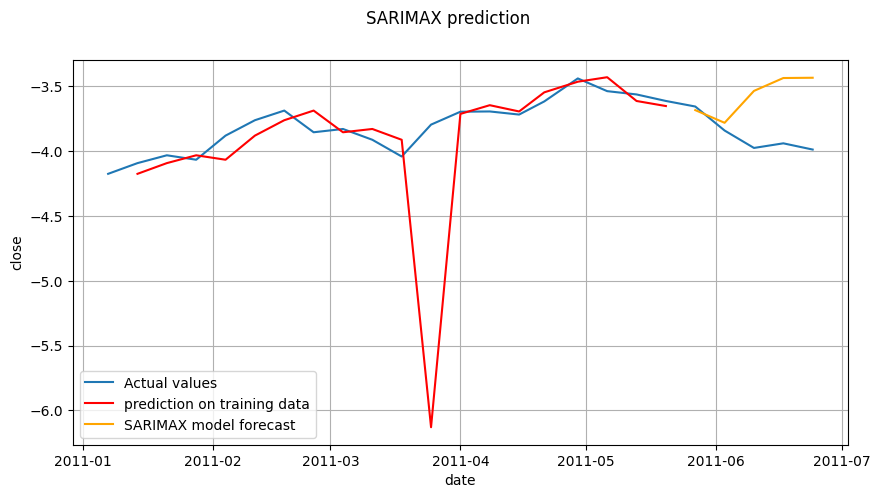

In [13]:
# The values for the predictions are not so good, but this does not matter since we only want to determine if we want to buy or sell
# from an index fund at a given day of the week, since we can not control the stock market anyway. In its most simple terms, 
# we only want to predict if the closing value will be higher or lower than it is currently. 

# Recreating the best model from above and making a prediction on the test set

# Fit the SARIMAX model
X_train = close_df_boxcox.iloc[:20]
X_test = close_df_boxcox.iloc[20:]
sarimax_model = SARIMAX(X_train, order=(0,1,2), seasonal_order=(0,1,0,11)).fit(disp=False)

prediction = sarimax_model.predict(start=X_train.index[1], end=X_train.index[-1], n_periods = len(X_train.index))
forecast = sarimax_model.forecast(steps=len(X_test))

# PLotting 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.suptitle(f'SARIMAX prediction')
sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', label='Actual values')
sns.lineplot(x=X_train.index[1:], y=prediction.values, color='red', label='prediction on training data')
sns.lineplot(y=forecast, x=X_test.index, color='orange', label='SARIMAX model forecast')
ax.grid()
plt.tight_layout
plt.legend()
plt.show()

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible sta

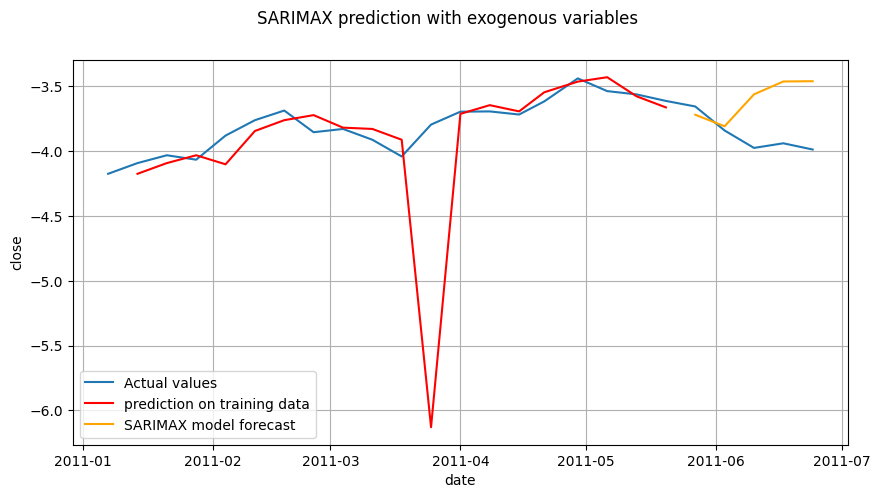

In [14]:
# SARAIMAX model be able to incorporate exogenous variables, such as the identified discords. Maybe this will make it better?

# Get the discords from earlier and make an ordered array with 1 where they appear, else 0.
top_three = sorted(list(profile), reverse=True)[:3]
discord_arr = np.array([1 if val in top_three and top_three.count(val) > 0 and top_three.remove(val) is None else 0 for val in profile])[:20].reshape(-1, 1)

# Fit the SARIMAX model
X_train = close_df_boxcox.iloc[:20]
X_test = close_df_boxcox.iloc[20:]
sarimax_model = SARIMAX(X_train, order=(0,1,2), seasonal_order=(0,1,0,11), exog=discord_arr).fit(disp=False)

prediction = sarimax_model.predict(start=X_train.index[1], end=X_train.index[-1], n_periods = len(X_train.index))
forecast = sarimax_model.forecast(steps=len(X_test), exog=np.zeros((5, 1)))     # Forecast requires exogenous variables to be provided as well. Here, we use a placeholder array with zeros since we can not predict the exogenous variables themselves. 

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.suptitle(f'SARIMAX prediction with exogenous variables')
sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', label='Actual values')
sns.lineplot(x=X_train.index[1:], y=prediction.values, color='red', label='prediction on training data')
sns.lineplot(y=forecast, x=X_test.index, color='orange', label='SARIMAX model forecast')
ax.grid()
plt.tight_layout
plt.legend()
plt.show()

# This did not improve the 

In [15]:
# Extending window SARIMAX
train, test = df['#Passengers'].iloc[:100], df['#Passengers'].iloc[100:]

print(len(test))
archive = [d for d in train]
predictions = list()
for i in range(len(test)): 
    model = SARIMAX(archive,order = (2,1,2),seasonal_order = (0,1,1,12)).fit(disp=False) 
    pred = model.forecast()[0]
    predictions.append(pred)
    archive.append(test.iloc[i])

print(predictions)


NameError: name 'df' is not defined

In [ ]:

# Function to make trades
def make_trade(capital, current_actual, current_prediction, next_actual, next_prediction, skip_if_statement=False):
    if np.abs(next_prediction) < np.abs(current_prediction) or skip_if_statement:
        percentage = np.abs(next_actual) / np.abs(current_actual)
        return np.round(float(capital * percentage), 2)
    else:
        return capital

# Function to evaluate trading strategy
def evaluate_trading_strategy(capital, X_test, forecast):
    trade_history = [capital]
    actual_history = [capital]
    for i in range(len(forecast) - 1):

        actual_change = make_trade(capital, 
                             current_actual=X_test.values[i], 
                             current_prediction=forecast.values[i], 
                             next_actual=X_test.values[i + 1], 
                             next_prediction=forecast.values[i + 1],
                             skip_if_statement=True)

        capital = make_trade(capital, 
                             current_actual=X_test.values[i], 
                             current_prediction=forecast.values[i], 
                             next_actual=X_test.values[i + 1], 
                             next_prediction=forecast.values[i + 1])

        trade_history.append(capital)
        actual_history.append(actual_change)
    return trade_history, actual_history

# Example usage
capital = 1000
trade_history, acutal_history = evaluate_trading_strategy(capital, X_test, forecast)
print(f'Traiding bot results: {trade_history}')
print(f'Reference market value: {acutal_history}')
